# Logistic Regression

## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch
from src.metrics import AccuracyScratch

## Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data[:1000, :, :].float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets[:1000]

# Transform the test data
X_val = mnist_testset.data[:100, :, :].float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets[:100]

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Theoretical Background

## Multilayer Perceptron From Scratch

Our network will have 2 hidden layers.

- W1: X with shape (num_samples, in_features) will be transformed by W1 (in_features, num_units) to Z1 with shape (num_samples, num_units).
- b1: b1 will be added to the matrix product of X and W1 which will be size (num_samples, num_units), so we will make it shape (num_units).
- W2: A1 with shape (num_samples, num_units) will be transformed by W2 (num_units, num_outpurs) to Z2 with shape (num_samples, num_classes).
- b2: b2 will be added to the matrix product of A1 and W2 which will be size (num_samples, num_classes), so we will make it shape (num_classes).

### Single Batch Iteration

In [3]:
# Create a batch
batch_size = 128
perm = torch.randperm(len(X_train))
X_batch = X_train[perm][:batch_size]
y_batch = y_train[perm][:batch_size]

in_features = X_train.shape[1]
num_units = 256
num_classes = y_train.unique().shape[0]


def relu(x):
    out = torch.maximum(x, torch.zeros(1))
    return out


def softmax(X):
    X_exp = torch.exp(X)
    X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
    return X_softmax


# Define the log-loss
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss


W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
b1 = nn.Parameter(torch.zeros(num_units))
W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
b2 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2]
optimizer = SGDScratch(parameters, lr=0.5)

In [4]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        Z1 = X_batch @ W1 + b1
        A1 = relu(Z1)
        Z2 = A1 @ W2 + b2
        y_pred = softmax(Z2)
        
        # Calculate Loss
        loss = log_loss(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

2.2759817838668823
2.1220027208328247
1.7286220788955688


In [5]:
get_shape = lambda x: tuple([x.shape[i] for i in range(len(x.shape))])

print("X_batch:", get_shape(X_batch))
print("W1:", get_shape(W1))
print("b1:", get_shape(b1))
print("Z1:", get_shape(Z1))
print("A1:", get_shape(A1))
print("W2:", get_shape(W2))
print("b2:", get_shape(b2))
print("Z2:", get_shape(Z2))
print("y_pred:", get_shape(y_pred))

X_batch: (128, 784)
W1: (784, 256)
b1: (256,)
Z1: (128, 256)
A1: (128, 256)
W2: (256, 10)
b2: (10,)
Z2: (128, 10)
y_pred: (128, 10)


### Define Training Loop and Model

In [6]:
class MLPScratch(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super().__init__()
        self.num_classes = num_classes
        self.W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_units))
        self.W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(num_classes))

    def relu(self, X):
        out = torch.maximum(X, torch.zeros(1))
        return out

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        # Forward pass
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        y_pred = self.softmax(Z2)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2]

In [7]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Define Training Loop and Model

Epoch 1/20, Training Loss: 2.2917, Validation Loss: 2.2704
Validation accuracy: 0.4300
Epoch 2/20, Training Loss: 2.2498, Validation Loss: 2.2078
Validation accuracy: 0.4700
Epoch 3/20, Training Loss: 2.1610, Validation Loss: 2.0720
Validation accuracy: 0.5700
Epoch 4/20, Training Loss: 1.9770, Validation Loss: 1.8273
Validation accuracy: 0.5700
Epoch 5/20, Training Loss: 1.6868, Validation Loss: 1.5233
Validation accuracy: 0.7100
Epoch 6/20, Training Loss: 1.3713, Validation Loss: 1.2493
Validation accuracy: 0.6500
Epoch 7/20, Training Loss: 1.1082, Validation Loss: 1.0475
Validation accuracy: 0.6800
Epoch 8/20, Training Loss: 0.9156, Validation Loss: 0.9176
Validation accuracy: 0.7300
Epoch 9/20, Training Loss: 0.7843, Validation Loss: 0.8343
Validation accuracy: 0.7500
Epoch 10/20, Training Loss: 0.6812, Validation Loss: 0.7334
Validation accuracy: 0.8000
Epoch 11/20, Training Loss: 0.6134, Validation Loss: 0.7361
Validation accuracy: 0.8000


Epoch 12/20, Training Loss: 0.5878, Validation Loss: 0.6841
Validation accuracy: 0.8100
Epoch 13/20, Training Loss: 0.5358, Validation Loss: 0.6641
Validation accuracy: 0.7900
Epoch 14/20, Training Loss: 0.5121, Validation Loss: 0.6042
Validation accuracy: 0.8200
Epoch 15/20, Training Loss: 0.4498, Validation Loss: 0.5496
Validation accuracy: 0.8600
Epoch 16/20, Training Loss: 0.4242, Validation Loss: 0.5452
Validation accuracy: 0.8500
Epoch 17/20, Training Loss: 0.4002, Validation Loss: 0.5286
Validation accuracy: 0.8500
Epoch 18/20, Training Loss: 0.3874, Validation Loss: 0.5409
Validation accuracy: 0.8200
Epoch 19/20, Training Loss: 0.3723, Validation Loss: 0.5206
Validation accuracy: 0.8600
Epoch 20/20, Training Loss: 0.3628, Validation Loss: 0.5316
Validation accuracy: 0.8000


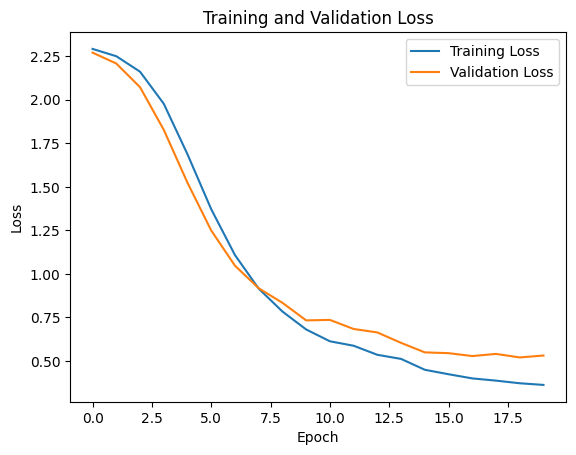

In [8]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
num_epochs = 20
learning_rate = 0.3

model = MLPScratch(in_features, num_classes, num_units)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy': AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of MLP

Epoch 1/10, Training Loss: 2.2140, Validation Loss: 2.0754
Validation accuracy: 0.5900
Epoch 2/10, Training Loss: 1.9226, Validation Loss: 1.7311
Validation accuracy: 0.6500
Epoch 3/10, Training Loss: 1.5197, Validation Loss: 1.3599
Validation accuracy: 0.7100
Epoch 4/10, Training Loss: 1.1606, Validation Loss: 1.0893
Validation accuracy: 0.6800
Epoch 5/10, Training Loss: 0.9309, Validation Loss: 0.9172
Validation accuracy: 0.7900
Epoch 6/10, Training Loss: 0.7534, Validation Loss: 0.8298
Validation accuracy: 0.7400
Epoch 7/10, Training Loss: 0.6581, Validation Loss: 0.7546
Validation accuracy: 0.8000
Epoch 8/10, Training Loss: 0.5884, Validation Loss: 0.7081
Validation accuracy: 0.7900
Epoch 9/10, Training Loss: 0.5199, Validation Loss: 0.6473
Validation accuracy: 0.8200
Epoch 10/10, Training Loss: 0.4880, Validation Loss: 0.6336
Validation accuracy: 0.8000


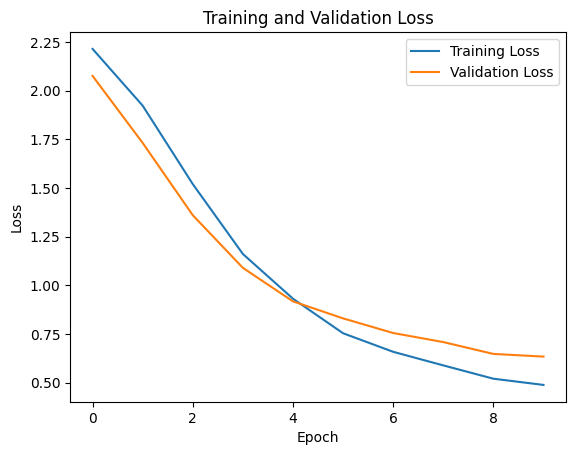

In [9]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, num_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_units, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
model = MLP(in_features, num_classes, num_units)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
metrics = {'accuracy': AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=10)